In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from scipy import stats

In [2]:
# create environment
class Discrete1DEnv:
    def __init__(self, nstates=5):
        self.states = np.arange(nstates) # number of discrete states. can be increased or decreased. Similar to taking discrete steps to the reward
        self.start_state = 1 # always start from state 1, such that the agent starts from the screen, after choice initiation
        self.reward_state = self.states[-2] # reward/terminal state is 1 before the final state.
        self.done = False # if done, trial ends and a new one begins
        self.maxt = 100 # max number of steps available for the agent to get to the reward state, afterwhich the trial ends and a new one begins.

    def reset(self): # start trial
        self.current_state = self.start_state # current state is the agent's current state
        self.done = False
        self.time = 0 # time = 0 for start
        return self.current_state

    def step(self, action=None):
      self.time+=1 # take a step in time

      # end trial if agent takes maxt steps and no reward
      if self.time >= self.maxt:
        self.done = True

      if action is None: # if no action specified, use optimal policy to move right
        if self.current_state < self.reward_state:
            self.current_state += 1
        else:
            self.done = True # end trial if agent reaches reward state
      else:
        if action == 0:
          self.current_state -= 1 # move back
        elif action == 1:
          self.current_state += 1 # move forward
        elif action == 2:
          self.current_state += 0 # stay
        else:
          raise ValueError("Invalid action. Must be 0, 1, or None.")

      # boundary conditions to prevent circular/unbounded environment
      if self.current_state < 0:
        self.current_state = 0
      elif self.current_state > len(self.states)-1:
        self.current_state = len(self.states)-1

      # reward contingency: no reward in other states
      if self.current_state == self.reward_state:
        reward = 1
        self.done = True # end trial if agent reaches reward state
      else:
        reward = 0

      return self.current_state, reward, self.done


In [3]:
# Agent implementation
class Agent:
    def __init__(self, gamma=0.95, eta=0.5, N=50, nstates=5, learn_policy=False, pf_type='simple', policy_prop=False, beta_alpha=0.0, sigma_init=0.5, weight_init=0.0):

        # hyperparameters
        self.N = N # number of place cells
        self.w = np.random.normal(size=self.N) * weight_init # random normal critic weights
        self.pftype = pf_type # complexity of place cell with/without amplitude
        self.lambdas = np.linspace(0, nstates-1, num=self.N) # initialized values for place field center of mass
        self.sigmas = np.ones(self.N) * sigma_init # initialized values for place field spread
        self.alphas = np.ones(self.N) * 1.0
        self.gamma0 = 1.0 # rich learning regime. keep to 1. originally 1/N for lazy regime
        # self.gamma0 = 1/self.N # weak learning regime
        self.gamma = gamma # TD error discount factor

        # policy hyperparams
        self.learn_policy = learn_policy # toggle True or False to learn a policy or use optimal policy
        self.nact = 3 # move back,  forward, or stay
        self.W = np.zeros([self.nact, self.N]) # actor weight for policy learning
        self.policy_prop = policy_prop

        self.beta_alpha = beta_alpha # regularization for alpha update
        self.eta = eta * self.gamma0**2 # learning rate
        self.trial_data = {
            'values': [],
            'td_errors': [],
            'lambdas': [],
            'states':[],
            'latencies':[],
            'sigmas':[],
            'alphas':[]
        }

        if pf_type == 'simple':
          self.phi = self.phi_simple
        elif pf_type == 'alpha':
          self.phi = self.phi_alpha
        elif pf_type == 'norm':
          self.phi = self.phi_norm

    def phi_simple(self, s): # simple place cell model with constant amplitude = 1 and variable center
        return np.exp(-(s - self.lambdas)**2 / (2 * self.sigmas**2))

    def phi_alpha(self, s): # place cell with variable amplitdue and center
        return self.sigmoid(self.alphas) * np.exp(-(s - self.lambdas)**2 / (2 * self.sigmas**2))

    # def phi_alpha(self, s):
    #     return self.alphas**2 * np.exp(-(s - self.lambdas)**2 / (2 * self.sigmas**2)) # from original paper, but not normalized

    def phi_norm(self, s):
        # return (1 / (self.sigmoid(self.sigmas) * np.sqrt(2*np.pi))) * np.exp(-(s - self.lambdas)**2 / (2 * self.sigmoid(self.sigmas)**2))
        return (1 / (self.sigmas * np.sqrt(2*np.pi))) * np.exp(-(s - self.lambdas)**2 / (2 * self.sigmas**2))

    def value(self, s):# place cell with normalized amplitude
        return 1/(self.gamma0*self.N) * np.sum(self.w * self.phi(s))

    def sigmoid(self,x):
        return 1/(1+np.exp(-x))

    def get_action(self,s):
        a_t = 1/(self.gamma0*self.N) * np.sum(self.W * self.phi(s),axis=1)
        P_t = np.exp(a_t) / np.sum(np.exp(a_t))
        action = np.random.choice(self.nact, p=P_t)
        g_t = np.zeros(self.nact)
        g_t[action] = 1
        self.gtilde = g_t - P_t
        return action

    def run_trial(self, env):
        state = env.reset()
        done = False
        trial_values = []
        trial_td_errors = []
        states = []

        while not done:

            if self.learn_policy:
              action = self.get_action(state)
            else:
              action = None

            next_state, reward, done = env.step(action)

            # compute TD error
            v_s = self.value(state)
            v_next = self.value(next_state) if not done else 0
            td_error = reward + self.gamma * v_next - v_s

            # compute gradients
            phi_s = self.phi(state)

            # Update critic weights
            # dw = delta_t * phi_t
            delta_w = td_error * phi_s
            self.w += self.eta * delta_w /(self.gamma0*self.N)

            # add constraint on w to be positive semi-definite
            # self.w = np.maximum(self.w, 0)

            if self.learn_policy:
              # update actor weights
              # dW = (g-P) @ phi_t * delta_t
              delta_W = self.gtilde[:,None] @ phi_s[None,:] * td_error
              self.W += self.eta * delta_W /(self.gamma0*self.N)

            # Update lambdas using only critic weights
            delta_lambda = td_error * self.w * phi_s * (state - self.lambdas) / self.sigmas
            if self.policy_prop:
              # Update lambdas using both actor & critic weights
              delta_lambda = td_error * (self.w + self.gtilde @ self.W) * phi_s * (state - self.lambdas) / self.sigmas
            self.lambdas += self.eta * delta_lambda /(self.gamma0*self.N)

            # update alphas
            if self.pftype == 'alpha':
              # delta_alpha = td_error * self.w * phi_s * (2/self.alphas)
              delta_alpha = td_error * self.w * phi_s * (1-self.sigmoid(self.alphas)) - self.beta_alpha * self.alphas
              # delta_alpha = td_error * self.w * phi_s * (2/self.alphas) - self.beta_alpha * self.alphas
              if self.policy_prop:
                  delta_alpha = td_error * (self.w + self.gtilde @ self.W) * phi_s * (1-self.sigmoid(self.alphas)) - self.beta_alpha * self.alphas
                  # delta_alpha = td_error * (self.w + self.gtilde @ self.W) * phi_s * (2/self.alphas) - self.beta_alpha * self.alphas
              self.alphas += self.eta * delta_alpha /(self.gamma0*self.N)

            # update sigmas
            # if self.pftype == 'sigma':
            #   delta_sigma = td_error * self.w * phi_s * (state - self.lambdas)**2 / self.sigmas**3
            #   self.sigmas += self.eta * delta_sigma

            # update norm
            if self.pftype == 'norm':
              delta_sigma = td_error * self.w * phi_s * (((state - self.lambdas)**2 / self.sigmas**3) - (1/self.sigmas))
              # delta_sigma = td_error * self.w * phi_s * ((((state - self.lambdas)**2 / self.sigmoid(self.sigmas)**2) -1) * self.sigmoid(self.sigmas)*(1-self.sigmoid(self.sigmas)))
              if self.policy_prop:
                delta_sigma = td_error * (self.w + self.gtilde @ self.W) * phi_s * (((state - self.lambdas)**2 / self.sigmas**3) - (1/self.sigmas))
                # delta_sigma = td_error * (self.w + self.gtilde @ self.W) * phi_s * ((((state - self.lambdas)**2 / self.sigmoid(self.sigmas)**2) -1) * self.sigmoid(self.sigmas)*(1-self.sigmoid(self.sigmas))  )
              self.sigmas += self.eta * delta_sigma /(self.gamma0*self.N)


            trial_values.append(v_s)
            trial_td_errors.append(td_error)
            states.append(state)
            state = next_state

        self.trial_data['values'].append(trial_values)
        self.trial_data['td_errors'].append(trial_td_errors)
        self.trial_data['lambdas'].append(self.lambdas.copy())
        self.trial_data['sigmas'].append(self.sigmas.copy())
        self.trial_data['alphas'].append(self.alphas.copy())
        self.trial_data['states'].append(states)
        self.trial_data['latencies'].append(env.time)

In [4]:
# Simulation
# agent params


learn_policy = True # If True, agent will learn a policy for noisier field updates. If False, agent uses optimal policy and we see smoother backward shifts
pf_type = 'simple' # 'simple', 'alpha', 'norm'
policy_prop = True # If True, update place cell parameters using policy weights too
beta_alpha = 0.0
weight_init = 0.0

N = 1000
eta0 = 0.1
sigma_scale = 0.5
gamma= 0.95
eta = eta0 * N

# assert that if policy_prop is True, learn_policy must be True
if policy_prop:
    assert learn_policy, "If policy_prop is True, learn_policy must be True"

# env params
num_trials = 500
nstates = 10

env = Discrete1DEnv(nstates)
agent = Agent(gamma, eta,N, nstates,learn_policy, pf_type, policy_prop, beta_alpha, sigma_scale, weight_init)

for t in range(num_trials):
    agent.run_trial(env)

    # add noise after N trials
    if (t+1)%20 == 0:
        agent.lambdas += np.random.normal(size=N) * 0.0

# Prepare data for plotting
states = env.states
trials = range(1, num_trials + 1)

# Create 3D arrays for values and TD errors (trials × states)
value_matrix = np.zeros((num_trials, len(states)))
td_matrix = np.zeros((num_trials, len(states)))

for trial in range(num_trials):
    for i, state in enumerate(agent.trial_data['states'][trial]):
        value_matrix[trial, state] = agent.trial_data['values'][trial][i]
        td_matrix[trial, state] = agent.trial_data['td_errors'][trial][i]

# Lambda values for each trial
sigmas = np.array(agent.trial_data['sigmas'])
lambdas = np.array(agent.trial_data['lambdas'])
alphas = np.array(agent.trial_data['alphas'])



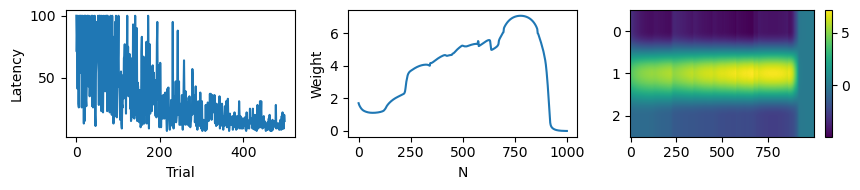

In [5]:
plt.figure(figsize=(9,2))
plt.subplot(131)
plt.plot(agent.trial_data['latencies'])
plt.ylabel('Latency')
plt.xlabel('Trial')
plt.subplot(132)
plt.plot(agent.w)
plt.ylabel('Weight')
plt.xlabel('N')
plt.subplot(133)
plt.imshow(agent.W,aspect='auto')
plt.colorbar()
plt.tight_layout()

In [6]:
# state meaning
state_meaning = {
    0: 'screen',
    1: 'choice',
    2: 'turn',
    3: 'walk',
    4: 'walk',
    5: 'stop',
    6: 'nose poke',
    7: 'lick',
    8: 'reward',
    9: 'ITI',
}

In [7]:
# classify cells based on threshold
threshold = 0.25
trial_idx = 25 # start from trial 0

ss = np.linspace(0, nstates, num=1001)
# ss = np.arange(nstates) # use discrete states for phi calculation

def get_phi(ss,lambdas, sigmas):
    return np.exp(-(ss[None,:] - lambdas[:,None])**2 / (2 * sigmas[:,None]**2))

phis = get_phi(ss, lambdas[trial_idx], sigmas[trial_idx])

# Find indices in ss that correspond to the interval [6, 8]
reward_interval_mask = (ss >= 7.5) & (ss <= 8)
rp = np.where(np.any(phis[:, reward_interval_mask] > threshold, axis=1))[0]


screen_interval_mask = (ss >= 0.5) & (ss <= 1.5)
sc = np.where(np.any(phis[:, screen_interval_mask] > threshold, axis=1))[0]

approach_interval_mask = (ss > 1.0) & (ss < 7.5) #& ~reward_interval_mask
ra_ = np.where(np.any(phis[:, approach_interval_mask] > threshold, axis=1))[0]
ra = np.setdiff1d(ra_, np.union1d(rp, sc))

print(f"Reward cells: {len(rp)}, Screen cells: {len(sc)}, Approach cells: {len(ra)}, Total cells: {len(rp) + len(sc) + len(ra)}")


Reward cells: 286, Screen cells: 259, Approach cells: 436, Total cells: 981


In [8]:
# # classify cells based on threshold
# threshold = 0.5
# trial_idx = 30 # start from trial 0

# ss = np.linspace(0, nstates, num=1001)
# # ss = np.arange(nstates) # use discrete states for phi calculation

# def get_phi(ss,lambdas, sigmas):
#     return np.exp(-(ss[None,:] - lambdas[:,None])**2 / (2 * sigmas[:,None]**2))

# phis = get_phi(ss, lambdas[trial_idx], sigmas[trial_idx])

# # Find indices in ss that correspond to the interval [6, 8]
# reward_interval_mask = (ss >= 7.5) & (ss <= 8)
# rp = np.where(np.any(phis[:, reward_interval_mask] > threshold, axis=1))[0]


# screen_interval_mask = (ss >= 0.5) & (ss <= 1.0)
# sc = np.where(np.any(phis[:, screen_interval_mask] > threshold, axis=1))[0]

# approach_interval_mask = (ss > 1.0) & (ss < 7.5) #& ~reward_interval_mask
# ra_ = np.where(np.any(phis[:, approach_interval_mask] > threshold, axis=1))[0]
# ra = np.setdiff1d(ra_, np.union1d(rp, sc))

# print(f"Reward cells: {len(rp)}, Screen cells: {len(sc)}, Approach cells: {len(ra)}, Total cells: {len(rp) + len(sc) + len(ra)}")


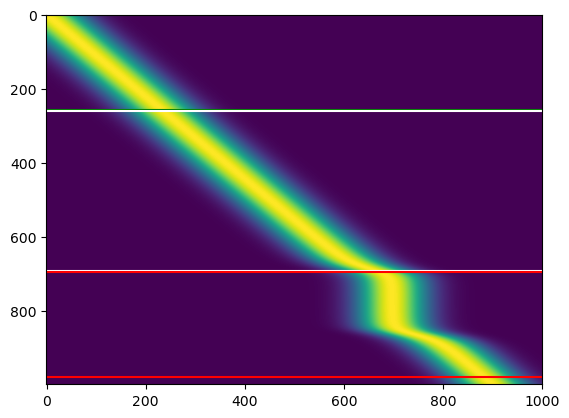

In [9]:
plt.imshow(phis,aspect='auto')
plt.axhline(sc[0],color='g')
plt.axhline(sc[-1],color='g')
plt.axhline(ra[0],color='w')
plt.axhline(ra[-1],color='w')
plt.axhline(rp[0],color='r')
plt.axhline(rp[-1],color='r')

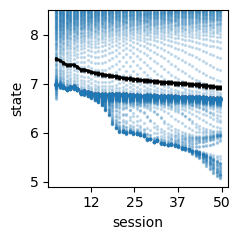

In [10]:
# Figure 3: Lambda values plot
downsample = 10
plt.figure(figsize=(2.5, 2.5))
cmap = cm.viridis
for i in rp:
    plt.scatter(trials[trial_idx:][::downsample], lambdas[trial_idx:, i][::downsample], s=2, color='tab:blue', alpha=0.2)
# plt.title('Lambda Parameter Evolution')
plt.ylabel('state')
plt.xlabel('session')
plt.yticks(range(len(states)), states)
plt.xticks(np.linspace(0,num_trials,5,dtype=int), np.linspace(0,num_trials,5,dtype=int)//downsample)  # Adjust x-ticks to show every 50 trials
# plt.xticks(yticks)
# plt.grid(True)
plt.ylim([4.9, 8.5])
# plt.gca().invert_yaxis()  # This ensures y increases downward

plt.errorbar(y=np.mean(lambdas[trial_idx:,rp],axis=1)[::downsample], x=trials[trial_idx:][::downsample], yerr=np.std(lambdas[trial_idx:,rp], axis=1)[::downsample]/np.sqrt(len(rp)), color='black', linewidth=2, label='Mean ± SD')

plt.tight_layout()
plt.savefig(f'./new_figs/rp_state_session_{learn_policy}.svg', bbox_inches='tight')

In [11]:
max_trial_idx = 500
drp = []
for i in rp:
    slope, intercept, r_value, p_value, std_err = stats.linregress(trials[trial_idx:max_trial_idx], lambdas[trial_idx:max_trial_idx,i])
    drp.append(r_value)
drp = np.array(drp)

dra = []
for i in ra:
    slope, intercept, r_value, p_value, std_err = stats.linregress(trials[trial_idx:max_trial_idx], lambdas[trial_idx:max_trial_idx,i])
    dra.append(r_value)
dra = np.array(dra)
dsc = []
for i in sc:
    slope, intercept, r_value, p_value, std_err = stats.linregress(trials[trial_idx:max_trial_idx], lambdas[trial_idx:max_trial_idx,i])
    dsc.append(r_value)
dsc = np.array(dsc)

all = []
for i in np.arange(N):
    slope, intercept, r_value, p_value, std_err = stats.linregress(trials[trial_idx:max_trial_idx], lambdas[trial_idx:max_trial_idx,i])
    all.append(r_value)
all = np.array(all)

[100.0, 0.0]
[98.62385321100918, 1.3761467889908257]
[50.19305019305019, 49.80694980694981]


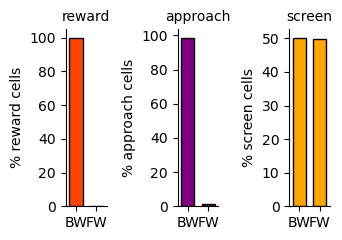

In [12]:
colors = ['orangered', 'purple','orange']
# data = [rp, ra, sc]
# drp = (lambdas[trial_idx:, rp] - lambdas[trial_idx, rp]).mean(axis=0) # mean evolution over trials for reward cells
# dar = (lambdas[trial_idx:, ra] - lambdas[trial_idx, ra]).mean(axis=0)  # mean evolution over trials for approach cells
# dsc = (lambdas[trial_idx:, sc] - lambdas[trial_idx, sc]).mean(axis=0)  # mean evolution over trials for screen cells
data = [drp, dra, dsc]

labels = ['reward', 'approach', 'screen']
f, ax = plt.subplots(1, 3, figsize=(3.5, 2.5))
for i in range(3):
    d = data[i]
    label = labels[i]
    bw = 100 * np.sum(d < 0) / len(d)  # backward shift
    fw = 100 * np.sum(d > 0) / len(d)  # forward shift
    print([bw,fw])
    ax[i].bar(['BW', 'FW'], [bw, fw], color=colors[i], width=0.65, edgecolor='black',)
    ax[i].set_ylabel(f'% {label} cells')
    ax[i].set_title(f'{label}', fontsize=10)
    ax[i].set_xlim(-0.5, 1.5)  # Add white space on both sides
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
f.tight_layout()
# plt.savefig(f'./new_figs/rp_ra_s_barplot_policy{learn_policy}.svg', bbox_inches='tight')
plt.savefig(f'./new_figs/rp_ra_s_barplot_policy{learn_policy}.eps', bbox_inches='tight')

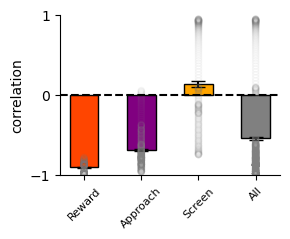

In [13]:
plt.figure(figsize=(3, 2.5))
data = [drp, dra, dsc, all]
labels = ['Reward', 'Approach', 'Screen', 'All']
colors = ['orangered', 'purple','orange', 'gray']
# Calculate means and standard errors
means = [np.mean(d) for d in data]
sems = [stats.sem(d) for d in data]

# Define colors with transparency (alpha=0.5)

x = np.arange(len(labels))
bars = plt.bar(x, means, yerr=sems, color=colors, capsize=5, edgecolor='black', width=0.5, zorder=1)

# plot individual data points as scatter
for i, dataset in enumerate(data):
    plt.scatter([i] * len(dataset), dataset, color='gray', alpha=0.05, s=20, zorder=2, facecolors='none', edgecolors='gray')

plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('correlation')
plt.xticks(x, labels, rotation=45, fontsize=8)

# Statistical significance markers
maxp = 0
for i, (dataset, label) in enumerate(zip(data, labels)):
    t_stat, p_val = stats.ttest_1samp(dataset, popmean=0)
    if p_val < 0.0001:
        sig_symbol = '****'
    elif p_val < 0.001:
        sig_symbol = '***'
    elif p_val < 0.01:
        sig_symbol = '**'
    elif p_val < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'ns'
    

    # maxp = np.max(means + sems + 0.01 * np.ptp(means))  # position above error bar
    # plt.text(i, maxp, sig_symbol, ha='center', va='bottom', fontsize=8, fontweight='bold')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(np.linspace(-1, 1.0, 3,dtype=int))
plt.ylim([-1,1])
plt.tight_layout()
plt.savefig(f'./new_figs/rp_ra_s_corr_policy{learn_policy}.svg',bbox_inches='tight')


In [14]:
# most backward shifting reward
print(rp[np.argmin(drp)], np.min(drp))

# least backward shifting reward
print(rp[np.argmax(drp)], np.max(drp))

# most backward shifting approach
print(ra[np.argmin(dra)], np.min(dra))

# least backward shifting approach
print(ra[np.argmax(dra)], np.max(dra))

922 -0.9998182454776036
855 -0.7810257161029611
573 -0.9672001026007828
259 0.05152470047144467


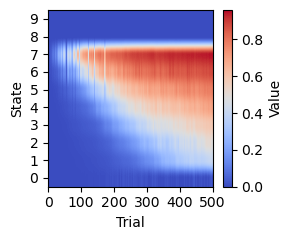

In [15]:
# Define yticks to use for all plots
yticks = np.linspace(0, num_trials, 6, dtype=int)

# Figure 1: Value function plot (flipped axes)
plt.figure(figsize=(3, 2.5))
im1 = plt.imshow(value_matrix.T, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(im1, label='Value')
plt.ylabel('State')
plt.xlabel('Trial')
plt.yticks(range(len(states)), states)
plt.xticks(yticks, yticks)
plt.gca().set_xticklabels(yticks)
plt.tight_layout()
plt.savefig(f'./new_figs/value_state_trial_policy{learn_policy}_flipped.svg', bbox_inches='tight')


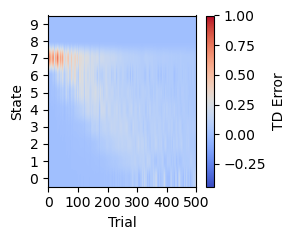

In [16]:
# Figure 2: TD error plot (flipped axes)
plt.figure(figsize=(3, 2.5))
im2 = plt.imshow(td_matrix.T, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(im2, label='TD Error')
plt.ylabel('State')
plt.xlabel('Trial')
plt.yticks(range(len(states)), states)
plt.xticks(yticks, yticks)
plt.gca().set_xticklabels(yticks)
plt.tight_layout()
plt.savefig(f'./new_figs/td_state_trial_policy{learn_policy}_flipped.svg', bbox_inches='tight')


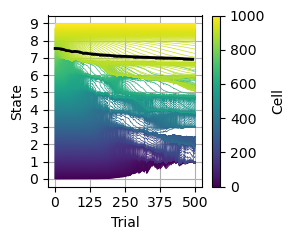

In [17]:
# Figure 3: Lambda values plot (flipped axes)
plt.figure(figsize=(3, 2.5))
cmap = cm.viridis
for i in range(agent.N):
    color = cmap(i / (N-1))
    plt.plot(trials, lambdas[:, i], color=color, linewidth=0.5, alpha=1)
plt.ylabel('State')
plt.xlabel('Trial')
plt.yticks(range(len(states)), states)
plt.xticks(np.linspace(0,num_trials,5,dtype=int), np.linspace(0,num_trials,5,dtype=int))
plt.grid(True)
norm = Normalize(vmin=0, vmax=N)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Cell')

# plt.errorbar(trials[::50], np.mean(lambdas, axis=1)[::50], yerr=np.std(lambdas, axis=1)[::50]/np.sqrt(N), color='black', linewidth=2, label='Mean ± SD')
plt.errorbar(y=np.mean(lambdas[:,rp],axis=1)[::downsample], x=trials[::downsample], yerr=np.std(lambdas[:,rp], axis=1)[::downsample]/np.sqrt(len(rp)), color='black', linewidth=2, label='Mean ± SD')

plt.tight_layout()
plt.savefig(f'./new_figs/lambda_state_trial_policy{learn_policy}_flipped.svg', bbox_inches='tight')


-2.9091608222269745 1.0089019006108522


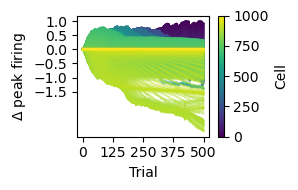

In [18]:
# Figure 5: Individual COM changes plot
plt.figure(figsize=(3, 2))
dlambdas = lambdas - lambdas[0]
for i in range(N):
    color = cmap(i / (N-1))
    plt.plot(np.arange(num_trials), dlambdas[:, i], color=color, zorder=1, alpha=0.5)

norm = Normalize(vmin=0, vmax=N)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Cell')
# plt.axvline(x=trial_idx, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.ylabel('$\Delta$ peak firing')
plt.xlabel('Trial')
plt.yticks([-1.5,-1.0, -0.5, 0.0, 0.5, 1.0])
plt.xticks(np.linspace(0,num_trials,5,dtype=int), np.linspace(0,num_trials,5,dtype=int))
plt.tight_layout()
# plt.savefig(f'./figs/delta_lambda_trial_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')
plt.savefig(f'./new_figs/delta_lambda_trial_policy{learn_policy}.svg', bbox_inches='tight')

print(dlambdas.min(), dlambdas.max())

(33,)


/var/folders/9w/2t7dk80j0vncsnz93dbrg1080000gp/T/ipykernel_87275/2591011806.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


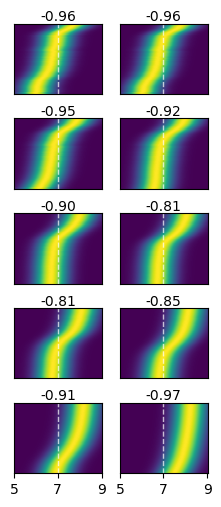

In [19]:
# Figure 6: The 10 small subplots in one figure
plt.figure(figsize=(2.5, 12))
inner_grid = gridspec.GridSpec(10, 2, wspace=0.2, hspace=0.35)

downsample = 10
maxtrials = 200
idx1 = lambdas[trial_idx] < 8.2
idx2 = lambdas[trial_idx] > 7.75
idx = idx1 * idx2
rp_small = np.arange(N)[idx]
print(rp_small.shape)
numplt = 10
idx12 = np.linspace(0, len(rp_small)-1, numplt, dtype=int)
rp12 = rp_small[idx12]

xs = np.linspace(5,9,100)
def get_phi(rpi):
    return np.exp(-(xs[None,:] - lambdas[trial_idx:,rpi][:,None])**2 / (2 * sigmas[trial_idx:,rpi][:,None]**2))

rxs = np.argmin(abs(xs-7))

for i in range(numplt):
    ax = plt.subplot(inner_grid[i])

    ax.imshow(get_phi(rp12[i])[:maxtrials], aspect='auto', cmap='viridis', origin='upper')

    # ax.imshow(phis[rp[i]][::downsample][:,5:9], aspect='auto', cmap='viridis', origin='upper')
    if i < numplt-2:
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.set_yticks([])
        ax.set_xticks([0, 49, 99])
        ax.set_xticklabels([5, 7, 9])
        
    ax.axvline(x=rxs, color='white', linestyle='--', linewidth=1, alpha=0.7)
    # ax.axvline(x=env.start_state, color='green', linestyle='--', linewidth=1, alpha=0.7)

    slope, intercept, r_value, p_value, std_err = stats.linregress(trials[trial_idx:], lambdas[trial_idx:,rp12[i]])
    # ax.set_ylabel(f'PF {rp[i]}', fontsize=8)
    ax.set_title(f'{r_value:.2f}',fontsize=10, pad=-0.1)
    # if i % 2 == 0:
    #     ax.set_ylabel('Trial', fontsize=8)
    if i >= 10:
        ax.set_xlabel('state',fontsize=10)
        # ax.set_xticks([env.start_state, env.reward_state])
        # ax.set_xticklabels(['Start', 'Reward'])

# plt.suptitle('Place Field Activity for Selected Cells', y=1.02)
plt.tight_layout()
# plt.savefig(f'./figs/example_lambda_session_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')
plt.savefig(f'./new_figs/example_lambda_session_policy{learn_policy}.svg', bbox_inches='tight')

[  0  26  52  78 105 131 157 183 210 236 262 288 315 341 367 393 420 446
 472 499]


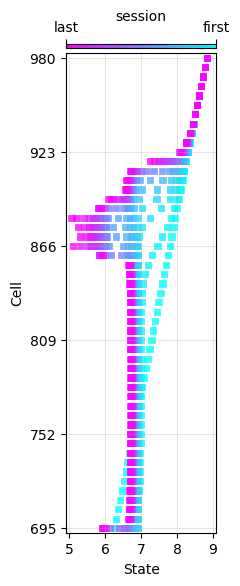

In [20]:
back_shift_cells = rp[np.linspace(0, len(rp)-1, 51, dtype=int)]  # Select first 10 reward cells for plotting

start_trial = 0
max_trial = 499
total_sessions = 20
# Create figure with appropriate dimensions
plt.figure(figsize=(2.5, 6))

# Create cool colormap for trials
cmap = plt.cm.cool
norm = plt.Normalize(vmin=0, vmax=max_trial)

# Sample every 10th trial (adjust as needed)
sampled_trials = np.linspace(start_trial, max_trial, total_sessions, dtype=int)
print(sampled_trials)

# Preallocate data for scatter plot
all_x = []
all_y = []
all_colors = []

# Collect data for plotting (vectorized approach)
for i, n in enumerate(back_shift_cells):  # Only first 10 cells as in your example
    cell_lambdas = lambdas[sampled_trials, n]
    all_x.extend(cell_lambdas)
    all_y.extend([i] * len(sampled_trials))
    all_colors.extend(cmap(norm(sampled_trials)))

# Single scatter plot call (much faster)
plt.scatter(all_x, all_y, c=all_colors, alpha=0.8, s=20, linewidths=0.5, marker='s')


# Place colorbar at the top of the figure (above the plot, where the title would be)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# Invert the colorbar by setting reverse limits
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='horizontal', pad=0.01, aspect=40, fraction=0.05, location='top')
cbar.ax.invert_xaxis()
# Set custom ticks and labels
cbar.set_ticks([0, max_trial])
cbar.set_ticklabels(['first', 'last'])
cbar.set_label('session', fontsize=10, labelpad=0)

# Formatting
plt.xlabel('State', fontsize=10)
plt.ylabel('Cell', fontsize=10)
plt.yticks(range(len(back_shift_cells))[::10], back_shift_cells[::10])  # Only show indices for plotted cells
plt.xlim([4.9,9.1])
plt.ylim([-0.5, len(back_shift_cells)-0.5])
plt.xticks(np.arange(5,10),np.arange(5,10))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'./new_figs/lambda_evolution_cool_policy{learn_policy}.svg',bbox_inches='tight')

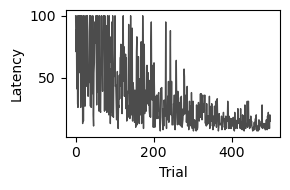

In [21]:
if learn_policy:
    plt.figure(figsize=(3,2))
    plt.plot(agent.trial_data['latencies'], linewidth=1, color='black', alpha=0.7)
    plt.ylabel('Latency')
    plt.xlabel('Trial')
    plt.tight_layout()
    # plt.savefig(f'./figs/latency_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')
    plt.savefig(f'./new_figs/latency_policy{learn_policy}.svg', bbox_inches='tight')

In [36]:
# backward shifting pf cause incorrect trials?
if learn_policy:
    correct_trials_idx = np.diff(np.array(agent.trial_data['latencies']))<0
    incorrect_trials_idx = np.diff(np.array(agent.trial_data['latencies']))>0

    idx1 = lambdas[0]<8.5
    idx2 = lambdas[0]>7
    idx = idx1 * idx2
    # idx = rp_idx

    # lambdas = np.array(agent.trial_data['lambdas'])
    # rp_idx1 = lambdas[0] < env.reward_state+0.25
    # rp_idx2 = lambdas[0] > env.reward_state-0.75
    # idx = rp_idx1 * rp_idx2

    idx = np.concatenate([rp,ra])
    # idx = rp



    print(correct_trials_idx.shape)

    correct_lambdas = []
    for i in np.arange(1, num_trials)[correct_trials_idx]:  # choose correct trials
        correct_lambdas.append((lambdas[i]-lambdas[i-1])[idx]) # filter out reward cells, see difference

    incorrect_lambdas = []
    for i in np.arange(1, num_trials)[incorrect_trials_idx]:
        incorrect_lambdas.append((lambdas[i]-lambdas[i-1])[idx])

    all_lambdas = []
    for i in np.arange(1, num_trials):
        all_lambdas.append((lambdas[i]-lambdas[i-1])[idx])

    incorrect_lambdas = np.array(incorrect_lambdas)
    correct_lambdas = np.array(correct_lambdas)
    all_lambdas = np.array(all_lambdas)


    print(correct_lambdas.shape)
    print(incorrect_lambdas.shape)
    print(all_lambdas.shape)

    print(np.mean(all_lambdas))
    print(np.mean(incorrect_lambdas))
    print(np.mean(correct_lambdas))
    


(499,)
(254, 722)
(224, 722)
(499, 722)
-0.0010673000965770753
-0.0020702856345195058
-0.0001642080163063233


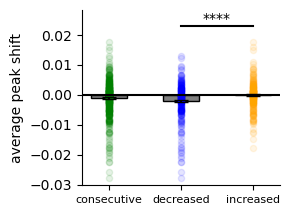

In [37]:
if learn_policy:
    plt.figure(figsize=(3, 2.25), facecolor='white')

    data = [np.mean(all_lambdas,axis=1), np.mean(incorrect_lambdas,axis=1), np.mean(correct_lambdas,axis=1)]
    # Calculate statistics
    means = [np.mean(d) for d in data]
    sems = [stats.sem(d) for d in data]

    labels = ['consecutive', 'decreased', 'increased']
    x_pos = np.arange(len(labels))
    outlier_colors = ['green', 'blue', 'orange']

    # Create bars with error bars
    bars = plt.bar(labels, means, width=0.5,
                color='gray',
                edgecolor='black',
                linewidth=1,
                yerr=sems,
                capsize=5)
    # plt.errorbar(labels, means, yerr=sems, fmt='o', capsize=5)

    # # Add mean lines on top of bars
    # for i, mean in enumerate(means):
    #     plt.plot([x_pos[i]-0.3, x_pos[i]+0.3], [mean, mean],
    #              color='black', linewidth=2)

    # Add outliers with original colors
    for i, d in enumerate(data):
        # Jitter x-position for visibility
        x_jittered = np.random.normal(x_pos[i], 0.00, size=len(d))
        plt.scatter(x_jittered, d,
                    color=outlier_colors[i],
                    alpha=0.1,
                    edgecolors=outlier_colors[i],
                    s=20)

    plt.ylabel('average peak shift')
    plt.xticks(x_pos, labels, fontsize=8)
    plt.axhline(y=0, color='black')

    # Keep your original significance testing code
    comparisons = [(0, 1), (0, 2), (1, 2)]
    y_max = max([np.max(d) for d in data])  # Find maximum y-value
    bar_levels = [y_max * 1.1, y_max * 1.2, y_max * 1.3]

    for (i, j), level in zip(comparisons, bar_levels):
        t_stat, p_val = stats.ttest_ind(data[i], data[j])
        if p_val < 0.001:
            symbol = '*' * min(4, int(-np.log10(p_val)) + 1)
            plt.plot([x_pos[i], x_pos[j]], [level, level], color='black')
            plt.text((x_pos[i]+x_pos[j])/2, level, symbol,
                    ha='center', va='bottom', fontsize=10)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.ylim(top=y_max * 1.6)
    plt.tight_layout()
    # plt.savefig(f'./figs/correct_incorrect_backshift_policy{learn_policy}.eps', dpi=300, bbox_inches='tight')
    # plt.savefig(f'./new_figs/correct_incorrect_backshift_policy{learn_policy}.svg', bbox_inches='tight')

In [38]:
def get_phi(ss,lambdas, sigmas):
    return np.exp(-(ss[None,:] - lambdas[:,None])**2 / (2 * sigmas[:,None]**2))


Text(0, 0.5, 'reward over-\nrepresentation')

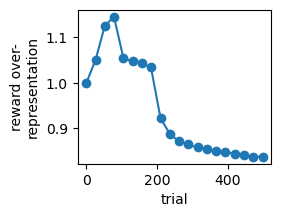

In [39]:
# plot number of cells at the reward location across trials

rep_ratio = []
sessions = np.linspace(0,num_trials-1, 20,dtype=int)
for t in sessions:
    phis = get_phi(ss, lambdas[t], sigmas[t])

    reward_interval_mask = (ss >= 7) & (ss <= 8)
    rp = np.where(np.any(phis[:, reward_interval_mask] > threshold, axis=1))[0]

    screen_interval_mask = (ss >= 0.5) & (ss <= 1.5)
    sc = np.where(np.any(phis[:, screen_interval_mask] > threshold, axis=1))[0]

    approach_interval_mask = (ss > 1.5) & (ss < 7.5) #& ~reward_interval_mask
    ra_ = np.where(np.any(phis[:, approach_interval_mask] > threshold, axis=1))[0]
    ra = np.setdiff1d(ra_, np.union1d(rp, sc))

    rep_ratio.append(len(rp))

rep_ratio = np.array(rep_ratio)
plt.figure(figsize=(2.5,2))
plt.plot(sessions, rep_ratio/rep_ratio[0], marker='o')
plt.xlabel('trial')
plt.ylabel('reward over-\nrepresentation')
# plt.savefig(f'./new_figs/reward_over_rep_policy{learn_policy}.svg',bbox_inches='tight')
